<span>Forecasting Precipitation in Australia</span>

## 1. Data Extraction from Excel File

In [5]:
!unzip -o data/australia_rain.zip -d data

Archive:  data/australia_rain.zip
  inflating: data/description.txt    
  inflating: data/australia_weather.xlsx  


In [6]:
import pandas as pd


# load data from excel file and store to parquet file

column_names = [
    'Date',
    'Location',
    'MinTemp',
    'MaxTemp',
    'Rainfall',
    'Evaporation',
    'Sunshine',
    'WindGustDir',
    'WindGustSpeed',
    'WindDir9am',
    'WindDir3pm',
    'WindSpeed9am',
    'WindSpeed3pm',
    'Humidity9am',
    'Humidity3pm',
    'Pressure9am',
    'Pressure3pm',
    'Cloud9am',
    'Cloud3pm',
    'Temp9am',
    'Temp3pm',
    'RainToday',
    'RISK_MM',
    'RainTomorrow',
]

df = pd.read_excel(
    io='data/australia_weather.xlsx',
    sheet_name='Sheet1',
    header=None,
    names=column_names,
    index_col=None,
    usecols="C:Z",
    skiprows=10,
    nrows=156412,
)

In [7]:
df = df.rename(columns={
    'Rainfall': 'PrecipitationToday', 
    'RISK_MM': 'PrecipitationTomorrow'
})
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'PrecipitationToday',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'PrecipitationTomorrow',
       'RainTomorrow'],
      dtype='object')

In [8]:
df.to_parquet('data/australia_weather.parquet')

## 2. Exploratory Data Analysis

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as mno

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 30)
sns.set()

In [11]:
df = pd.read_parquet('data/australia_weather.parquet')

In [12]:
train, test = train_test_split(df, test_size=0.2, random_state=123)

In [13]:
numeric_features = train.select_dtypes(include=["float64"])
cat_features = train.select_dtypes(include=["object"])

### Values in the dataset

Mostly real numbers. The rest is date and categorical data.

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125129 entries, 48558 to 15725
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   125129 non-null  object 
 1   Location               125129 non-null  object 
 2   MinTemp                124569 non-null  float64
 3   MaxTemp                124842 non-null  float64
 4   PrecipitationToday     123902 non-null  float64
 5   Evaporation            71530 non-null   float64
 6   Sunshine               65451 non-null   float64
 7   WindGustDir            116908 non-null  object 
 8   WindGustSpeed          116963 non-null  float64
 9   WindDir9am             116329 non-null  object 
 10  WindDir3pm             121818 non-null  object 
 11  WindSpeed9am           123931 non-null  float64
 12  WindSpeed3pm           122794 non-null  float64
 13  Humidity9am            123556 non-null  float64
 14  Humidity3pm            121932 non

## Problems with the data

### Duplicates

In [15]:
# Count of duplicated rows
train.loc[train.duplicated()].shape

(9104, 24)

In [16]:
train.drop_duplicates(inplace=True)

### Missing values

4 features are missing over 40% - 50% rows, other 5 are missing 6% - 10% rows and the rest have below 3% of missing rows.

<Axes: >

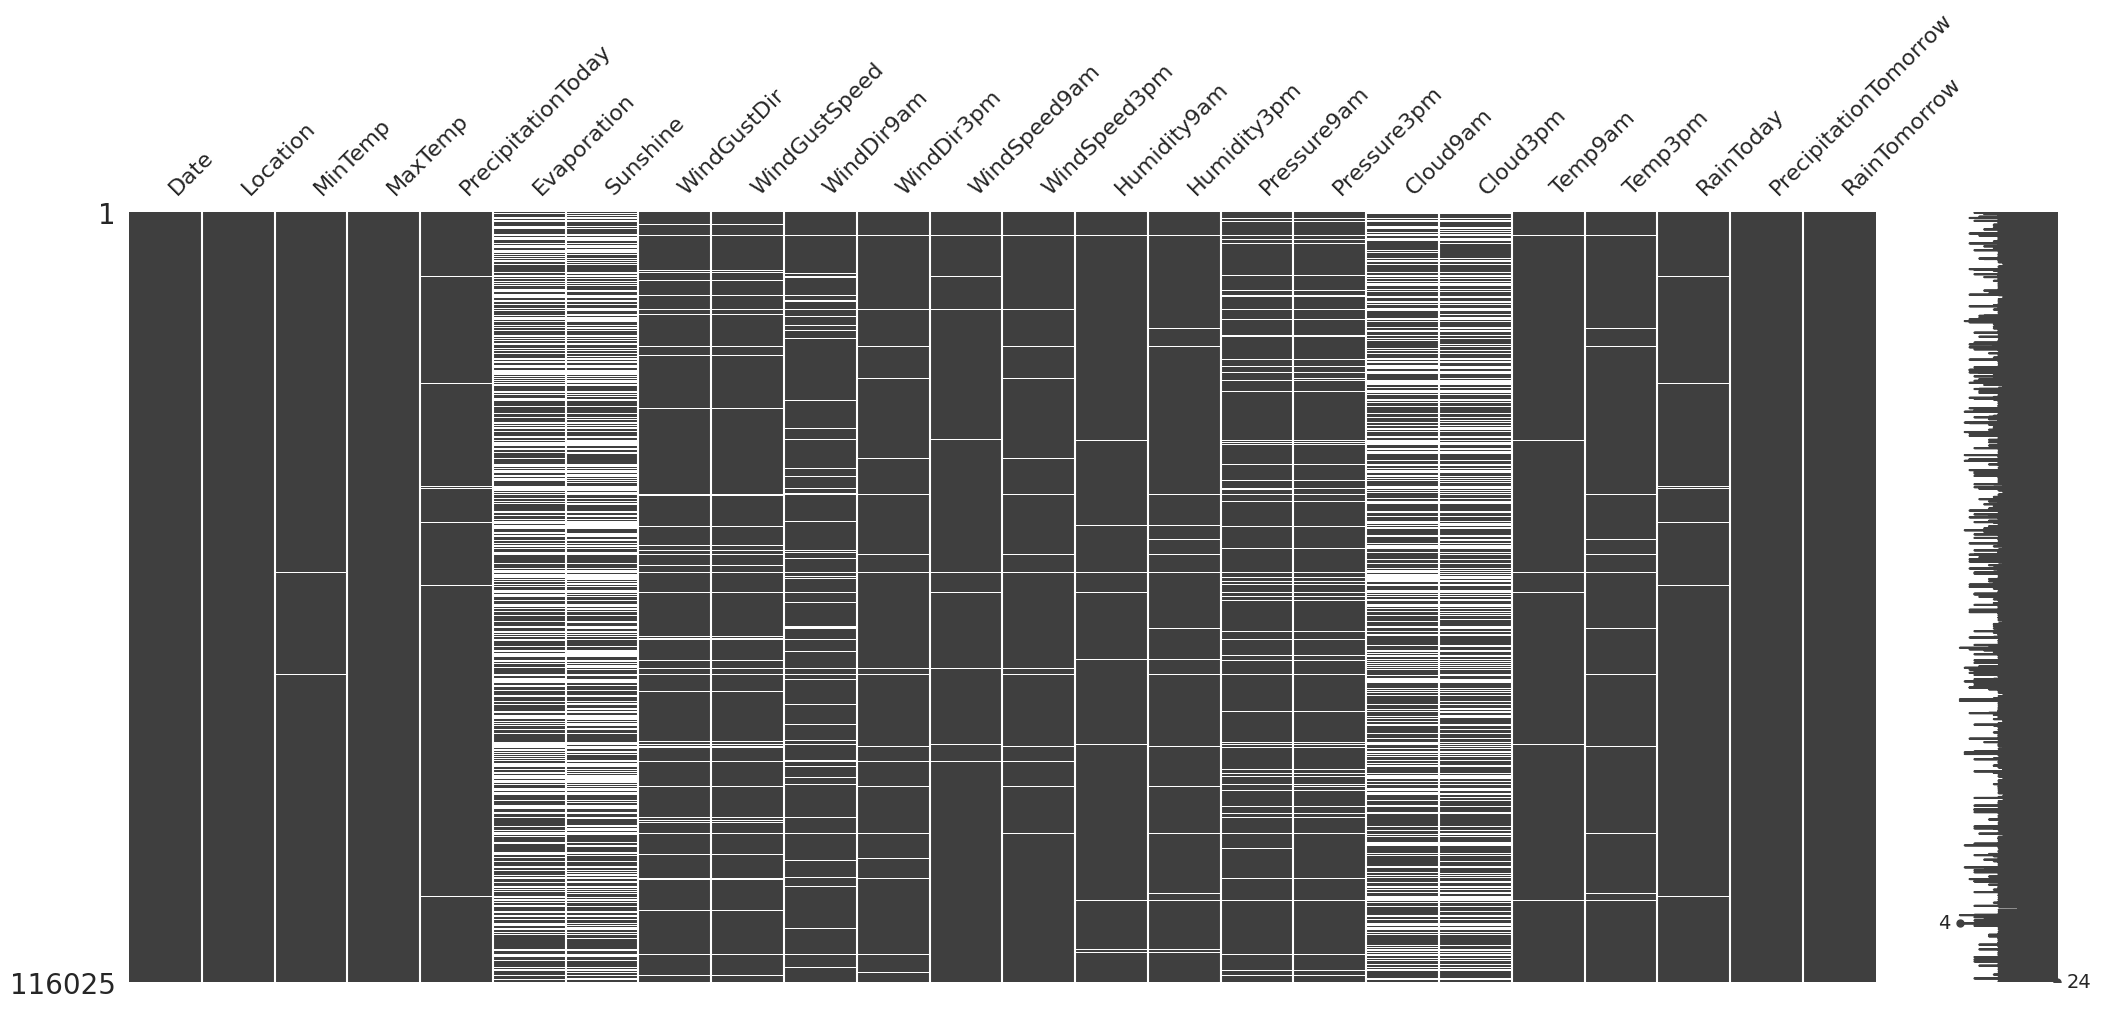

In [17]:
mno.matrix(train.sort_values(by='Date'))

In [18]:
# percentages of missing values

null_percentages = (train.isna().sum() / len(train) * 100)
keep_columns = null_percentages[null_percentages > 0]
pd.Series.sort_values(keep_columns, ascending=False).map(lambda x: f'{x:.2f}%')

Sunshine              47.74%
Evaporation           42.84%
Cloud3pm              40.19%
Cloud9am              37.77%
Pressure9am            9.82%
Pressure3pm            9.80%
WindDir9am             7.04%
WindGustDir            6.55%
WindGustSpeed          6.50%
WindDir3pm             2.64%
Humidity3pm            2.55%
Temp3pm                1.93%
WindSpeed3pm           1.86%
Humidity9am            1.26%
RainToday              0.99%
PrecipitationToday     0.99%
WindSpeed9am           0.95%
Temp9am                0.65%
MinTemp                0.45%
MaxTemp                0.23%
dtype: object

### Outliers

Pressure has extreme outliers. We noticed that it might be an error in units, so we fix it in preprocessing.

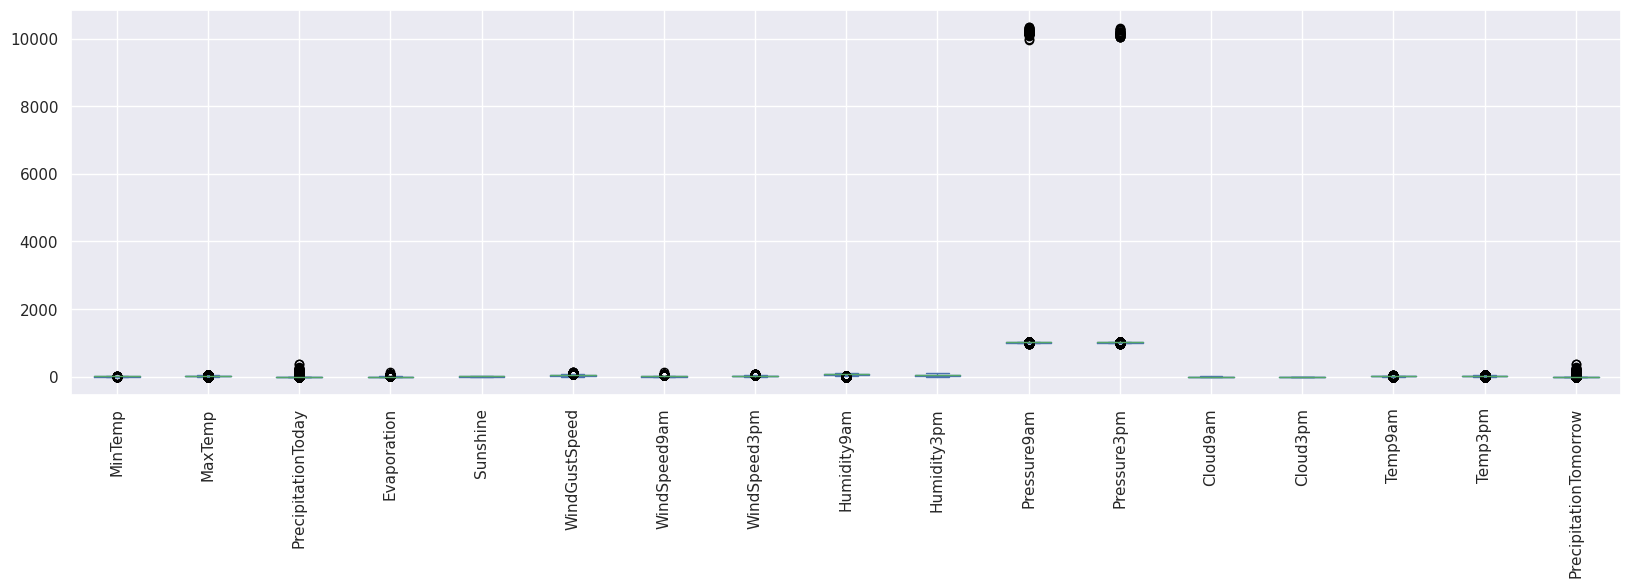

In [19]:
# outliers

numeric_features.plot(figsize=(20, 5), kind="box", rot=90)
plt.show()

In [20]:
numeric_features = numeric_features.query("Pressure9am < 5000").query("Pressure3pm < 5000")

Precipitation, Wind speed  and Evaporation also have significant outliers.

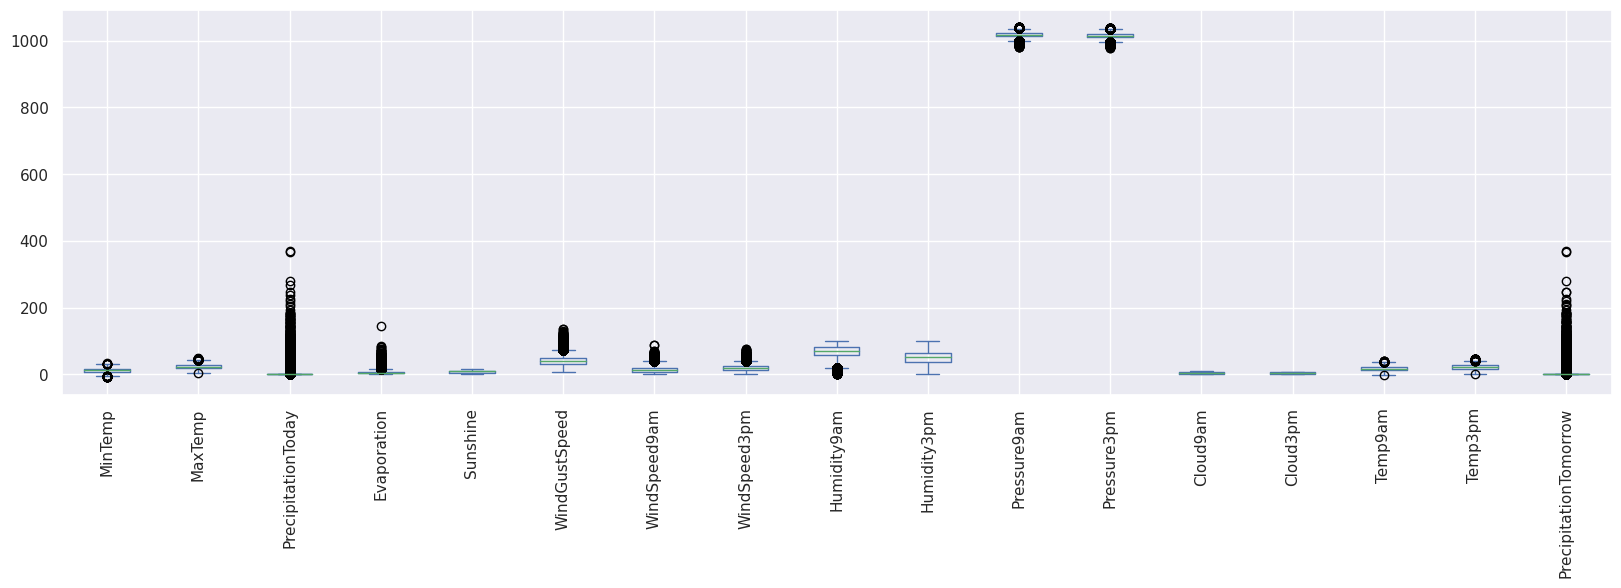

In [21]:
numeric_features.plot(figsize=(20, 5), kind="box", rot=90)
plt.xticks(rotation=90)
plt.show()

## Data distributions

According to histograms, we can assume that Temperature, Humidity, Wind speed, Sunshine and Pressure(without outliers) have normal distributions. For the remaining features it's more difficult to assume, because outliers distort the graphs.

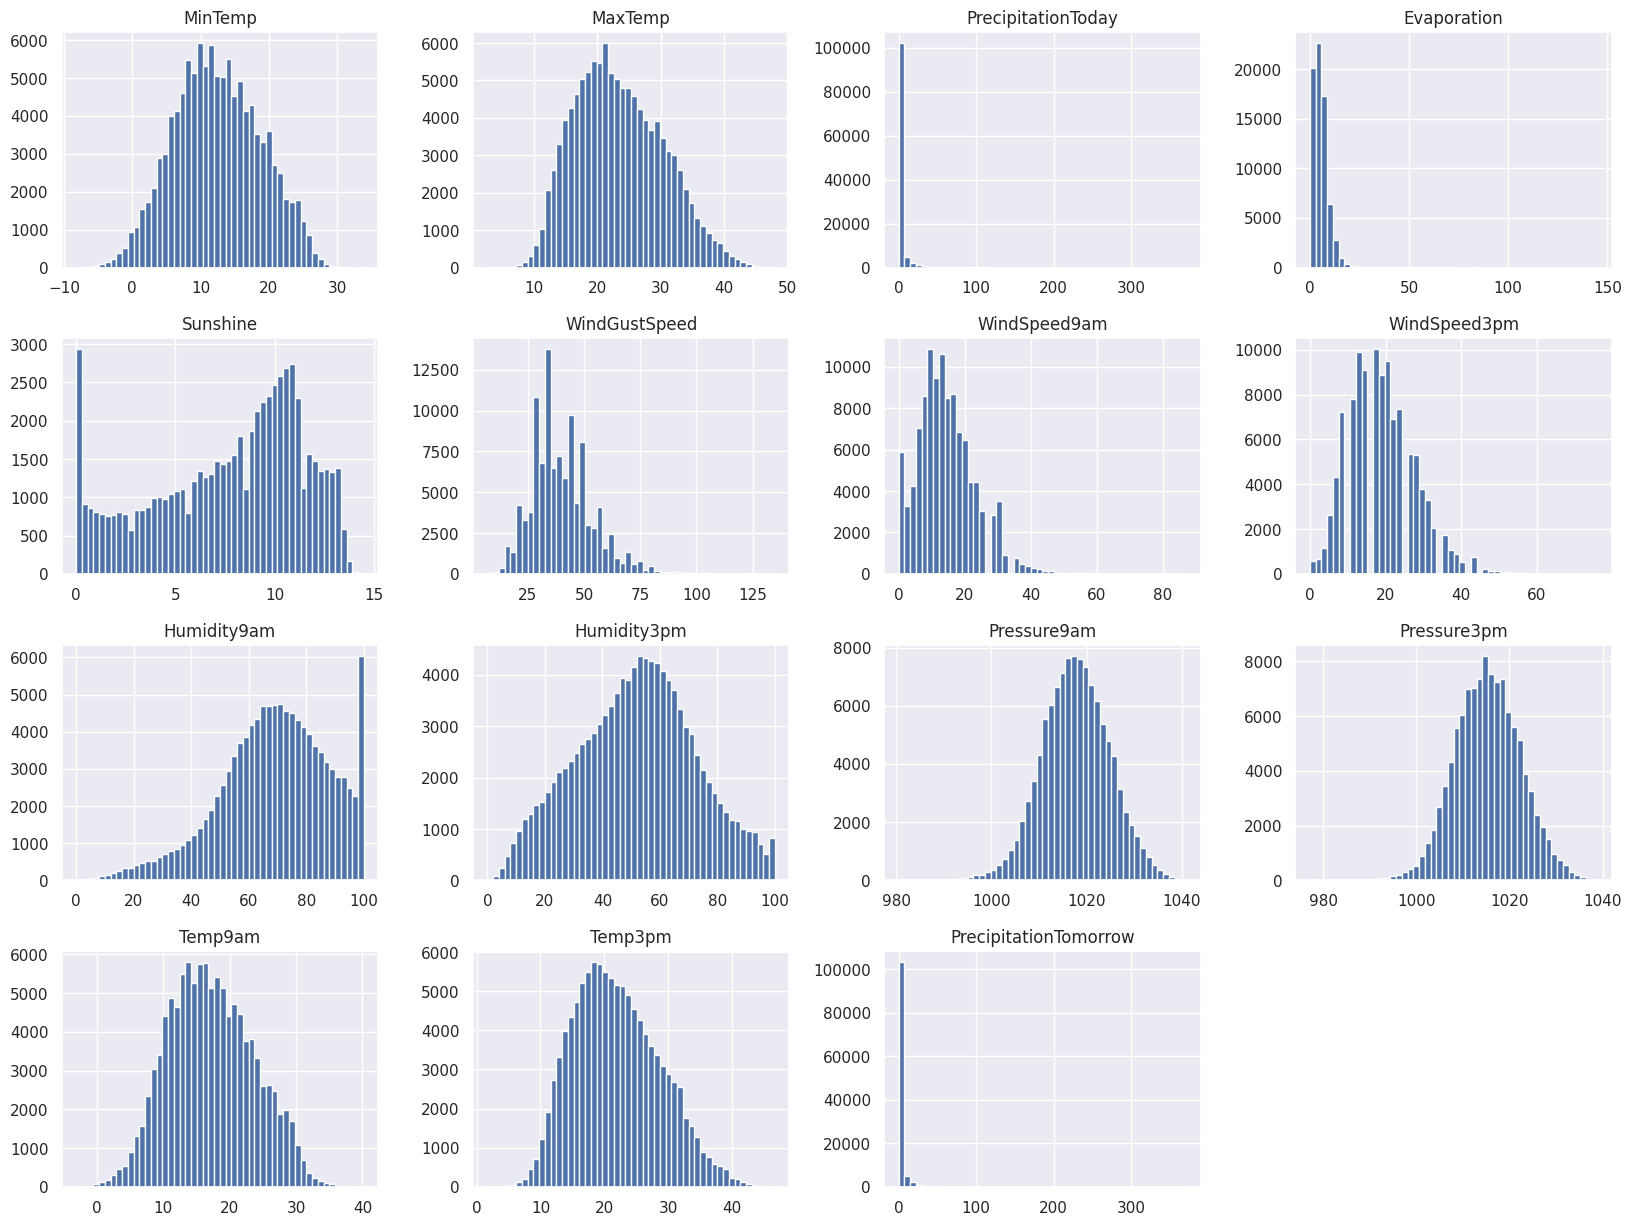

In [22]:
# distributions of numeric columns
# Cloud features are numeric but behave as categorical with discrete values from 0 to 8
numeric_without_cloud = numeric_features.drop(columns=["Cloud9am", "Cloud3pm"])
numeric_without_cloud.hist(figsize=(20, 15), bins=50)
plt.show()

According to the normal test, each feature have p-value less than 0.00, therefore we can reject the null hypothesis and assume that all features have normal distributions. For the features with significant outliers, we can see that z-scores are high and therefore the graphs were skewed.

In [23]:
from scipy.stats import normaltest
print('%22s  %10s  %s' % ("Column", "Statistic", "P value"))
print("-------------------------------------------------")
for column in numeric_without_cloud:
    stat, p_val = normaltest(numeric_without_cloud[column], nan_policy="omit")
    print('%22s  %10.2f  %.2f' % (column, stat, p_val))

                Column   Statistic  P value
-------------------------------------------------
               MinTemp     2544.23  0.00
               MaxTemp     4052.95  0.00
    PrecipitationToday   176514.26  0.00
           Evaporation    63586.50  0.00
              Sunshine     8457.13  0.00
         WindGustSpeed    13865.07  0.00
          WindSpeed9am    11050.33  0.00
          WindSpeed3pm     7932.53  0.00
           Humidity9am     3917.18  0.00
           Humidity3pm     2325.96  0.00
           Pressure9am      394.86  0.00
           Pressure3pm      108.21  0.00
               Temp9am     2584.20  0.00
               Temp3pm     3339.82  0.00
 PrecipitationTomorrow   176955.67  0.00


## Relationships in the data

Significant positive correlations: Evaporation and Temperature, Sunshine and Temperature, Sunshine and Evaporation, Clouds and Humidity. 

Significant negative correlations: Humidity and Temperature, Pressure and Temperature, Pressure and Wind speed, Humidity and Sunshine, Humidity and Evaporation, Clouds and Sunshine.

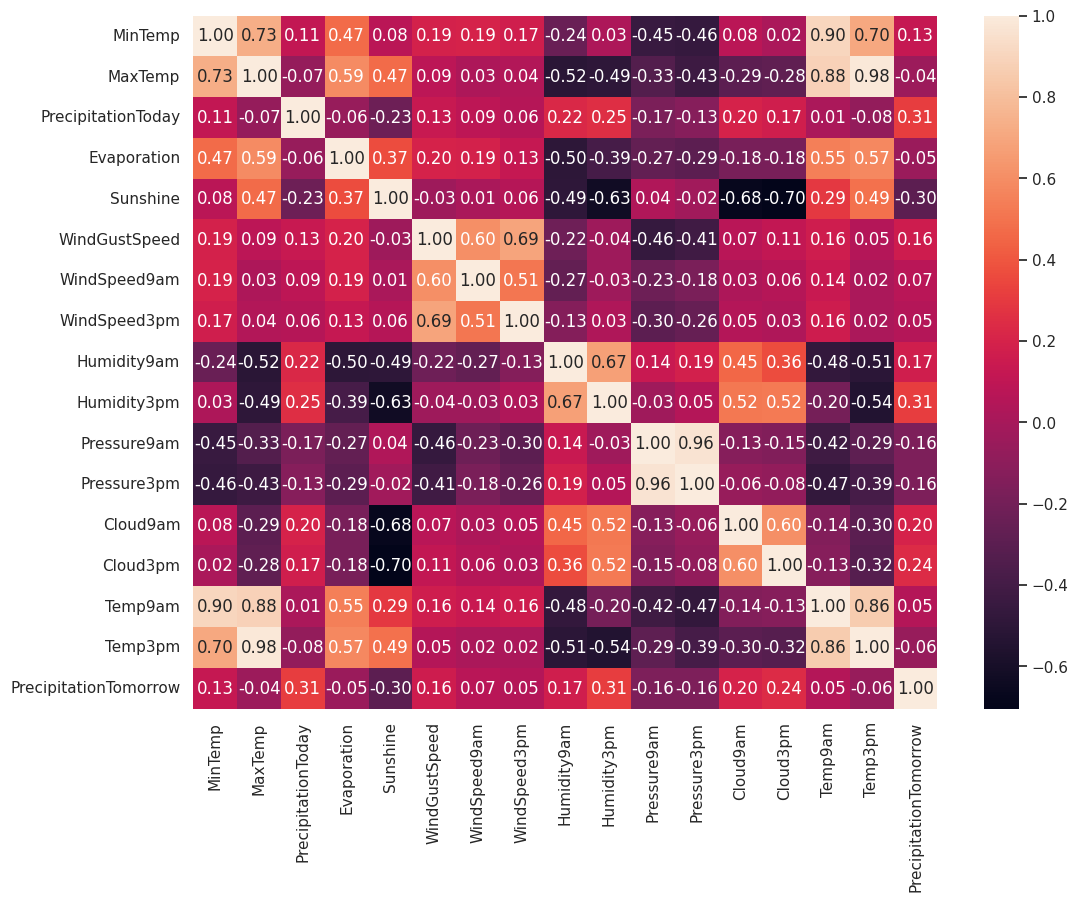

In [24]:
# correlation matrix

sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap(numeric_features.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()

# Preprocessing

In [25]:
# import libraries

import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import random

from IPython.display import Image
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from shapely.geometry import Point
from geopy.geocoders import Nominatim


# set options

pd.set_option('display.max_columns', 30)
sns.set()

In [27]:
# load dataset

df = pd.read_parquet("data/australia_weather.parquet")

In [28]:
# drop all duplicate rows

df.drop_duplicates(inplace=True)

In [29]:
# Keep only rows with defined prediction value

df = df[df['PrecipitationTomorrow'].notna()]

In [30]:
# Add month as a feature

df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df["Month"] = df.Date.dt.month_name()

In [31]:
# Pressure outliers are order of magnitude higher than the rest. 
# We assume that it was a systematic error and we scale them down.

df['Pressure3pm'] = df['Pressure3pm'].apply(lambda x: x / 10 if x >= 5000 else x)
df['Pressure9am'] = df['Pressure9am'].apply(lambda x: x / 10 if x >= 5000 else x)

### Clustering of locations

The `Location` feature in the dataset contained too many categorical values (49). We needed a way to reduce the amount of categorical values to reduce over-fitting. We hypothesised that the weather might be similar for some of the locations. We backed this claim by visualizing the locations on a map of Australia and comparing it with a map depicting the yearly rainfall for Australia (the maps can be seen below). Moreover, we visualized the distribution of precipitation for each location cluster and concluded that the distributions are different.

We therefore clustered the locations based to their geographical coordinates and replaced the `Location` feature with the appropriate cluster for the given location. This reduced the amount of categorical values for `Location` from 49 to 9.

In [32]:
# Gets the coordinates for each location and
# creates geopandas dataframe with city location and coordinates.

locations = {
    "Location": [],
    "Coordinates": [],
    "Longitude": [],
    "Latitude": [],
    }

geolocator = Nominatim(user_agent="Geolocation")

for location in df['Location'].unique():
    city = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', location)
    loc = geolocator.geocode(f"{city}, Australia")
    locations["Location"] += [location]
    locations["Coordinates"] += [(loc.longitude, loc.latitude)]
    locations["Longitude"] += [loc.longitude]
    locations["Latitude"] += [loc.latitude]


# The 'Coordinates' feature is transformed into a Point object
# so that we can later draw the locations on a map.
locations = pd.DataFrame.from_dict(locations)
locations["Coordinates"] = locations["Coordinates"].apply(Point)

gdf = gpd.GeoDataFrame(locations, geometry="Coordinates")

In [ ]:
# using KMeans to cluster city locations according to coordinates

k = 9
X = gdf[['Latitude', 'Longitude']].values

kmeans = KMeans(
    n_clusters=k,
    n_init=10,
    random_state=0
)

gdf['Cluster'] = kmeans.fit_predict(X)

: 

In [ ]:
# draws the clustered locations on map

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

fig, gax = plt.subplots(figsize=(10,10))
world.query("name == 'Australia'").plot(ax=gax, edgecolor='black',color='white')

colors = sns.color_palette()

# Plot the locations colored by cluster
for i in range(k):
    plt.scatter(X[kmeans.labels_ == i, 1], X[kmeans.labels_ == i, 0], s=50, c=colors[i], label=f"Cluster {i}")

# Plot the boundaries of clusters
for i in range(k):
    cluster_center = kmeans.cluster_centers_[i]
    cluster_radius = np.max(np.linalg.norm(X[kmeans.labels_ == i] - cluster_center, axis=1))
    circle = plt.Circle((cluster_center[1], cluster_center[0]), cluster_radius, color=colors[i], fill=False)
    plt.gcf().gca().add_artist(circle)

gax.set_title('Australia rain locations')
gax.set_xlabel('Longitude')
gax.set_ylabel('Latitude')
plt.legend()
plt.show()

: 

In [ ]:
# add new cluster feature to dataset

location_to_cluster = {
    location: cluster for cluster, location in gdf[["Cluster", "Location"]].values
}

locations = df["Location"].copy(deep=True)

df["Cluster"] = np.vectorize(lambda x: location_to_cluster[x])(locations)

: 

In [ ]:
# checking whether each cluster has a different distribution

sns.boxenplot(x=df["Cluster"], y=df["PrecipitationTomorrow"])
plt.title("Distribution of precipitation for each cluster")

: 

In [ ]:
# Retype object columns to category type

object_cols = df.select_dtypes("object").columns
df[object_cols] = df[object_cols].astype("category")

df['Cluster'] = df['Cluster'].astype("category")

: 

In [ ]:
# Drop columns that aren't needed
# dropping 'Date' since we have extracted the month information
# dropping 'RainTomorrow' to prevent data leakage
# dropping 'RainToday' since it's calculated from `PrecipitationToday`
not_needed = ['Date', 'RainTomorrow', 'RainToday']
df.drop(not_needed, axis=1, inplace=True)

# Drop columns with too many missing values
# Sunshine              47.74%
# Evaporation           42.84%
# Cloud3pm              40.19%
# Cloud9am              37.77%
too_many_missing = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
df.drop(too_many_missing, axis=1, inplace=True)

# Drop location column
# We have already extracted the location information into the cluster column
# We can drop the location column since it's not needed anymore
df.drop(['Location'], axis=1, inplace=True)

: 

In [ ]:
# train/test split

# using the same seed that was used in EDA
train, test = train_test_split(df, test_size=0.2, random_state=123)

train_X, train_y = train.drop(["PrecipitationTomorrow"], axis=1), train["PrecipitationTomorrow"]
test_X, test_y = test.drop(["PrecipitationTomorrow"], axis=1), test["PrecipitationTomorrow"]

: 

### Wind direction transformer

Each of the features `WindGustDir`, `WindDir9am`, and `WindDir3pm` had too many categorial values (16). We needed to reduce the amount of categorial values to reduce over-fitting. This was done by converting the directions into floats which represented the angle of the direction.

We got this idea from [research paper](https://www.researchgate.net/publication/359513858_Prediction_of_Rainfall_in_Australia_Using_Machine_Learning): 
_Cabezuelo, Antonio. (2022). Prediction of Rainfall in Australia Using Machine Learning. Information. 13. 163. 10.3390/info13040163._ 

In [ ]:
from math import radians, cos, sin


def wind_dir_to_degrees(wind_dir):
    if wind_dir == "N":
        return 0
    if wind_dir == "NNE":
        return 25
    if wind_dir == "NE":
        return 45
    if wind_dir == "ENE":
        return 65
    if wind_dir == "ESE":
        return 115
    if wind_dir == "SE":
        return 135
    if wind_dir == "SSE":
        return 155
    if wind_dir == "S":
        return 180
    if wind_dir == "SSW":
        return 205
    if wind_dir == "SW":
        return 225
    if wind_dir == "WSW":
        return 245
    if wind_dir == "WNW":
        return 295
    if wind_dir == "NW":
        return 315
    if wind_dir == "NNW":
        return 335

    # Value for direction W.
    # W is most_frequent so we impute it as well for the missing values.
    return 270


def get_cos_from_wind_dir(wind_dir):
    degrees = wind_dir_to_degrees(wind_dir)
    return cos(radians(degrees))


def get_sin_from_wind_dir(wind_dir):
    degrees = wind_dir_to_degrees(wind_dir)
    return sin(radians(degrees))


def WindDir_To_Sin_Cos_Converter_func(data):
    features = ["WindGustDir", "WindDir9am", "WindDir3pm"]

    for item in features:
        data[f"{item}_Sin"] = data[item].apply(
            lambda value: get_sin_from_wind_dir(value)
        )
        data[f"{item}_Cos"] = data[item].apply(
            lambda value: get_cos_from_wind_dir(value)
        )

    return data.drop(features, axis=1)


# transformer that is used in the final preprocessing pipeline
WindDir_To_Sin_Cos_Converter = FunctionTransformer(WindDir_To_Sin_Cos_Converter_func)


: 

### Outlier remover

As visualized in the exploratory data analysis, the features contain many outliers. To prevent the models from over-fitting the outlier data, we remove the outliers with a IQR remover. We also tried using a ZScore remover, however, the results were significantly better for the IQR remover.

In [ ]:
exclude_cols = []


def IQR_Outliers(data, features):
    out_indexlist = []

    for col in features:
        # Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(data[col], 25.0)
        Q3 = np.nanpercentile(data[col], 75.0)

        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off

        outliers_index = data[col][
            (data[col] < lower) | (data[col] > upper)
        ].index.tolist()
        out_indexlist.extend(outliers_index)

    out_indexlist = list(set(out_indexlist))
    out_indexlist.sort()

    return out_indexlist


def IQR_Outliers_Remover_func(data):
    numeric_features = data.select_dtypes(include=["float64"]).drop(
        exclude_cols, axis=1
    )
    outliers = IQR_Outliers(data, numeric_features.columns)

    return data.drop(outliers)


def IQR_Outliers_rows(data):
    numeric_features = data.select_dtypes(include=["float64"]).drop(
        exclude_cols, axis=1
    )
    return IQR_Outliers(data, numeric_features.columns)


# transformer that is used in the final preprocessing pipeline
IQR_Outliers_Remover = FunctionTransformer(IQR_Outliers_Remover_func)


: 

In [ ]:
def ZScore_Outliers (data, features):
    out_indexlist = []

    for col in features:
        upper_limit = data[col].mean() + 3 * data[col].std()
        lower_limit = data[col].mean() - 3 * data[col].std()
                
        outliers_index = data[col][(data[col] < lower_limit) | (data[col] > upper_limit)].index.tolist()
        out_indexlist.extend(outliers_index)

    out_indexlist = list(set(out_indexlist))
    out_indexlist.sort()

    return out_indexlist

def ZScore_Outliers_Remover_func(data):
    numeric_features = data.select_dtypes(include=["float64"])
    outliers = ZScore_Outliers(data, numeric_features.columns)

    return data.drop(outliers)

ZScore_Outliers_Remover = FunctionTransformer(ZScore_Outliers_Remover_func)

def ZScore_Outliers_rows(data):
    numeric_features = data.select_dtypes(include=["float64"])
    return ZScore_Outliers(data, numeric_features.columns)

: 

In [ ]:
numeric_features = [
    'MinTemp', 'MaxTemp',
    'PrecipitationToday',
    'WindGustSpeed',
    'WindSpeed9am', 'WindSpeed3pm',
    'Humidity9am', 'Humidity3pm',
    'Pressure9am', 'Pressure3pm', 
    'Temp9am', 'Temp3pm',
    'WindGustDir_Sin', 'WindGustDir_Cos',
    'WindDir9am_Sin', 'WindDir9am_Cos',
    'WindDir3pm_Sin', 'WindDir3pm_Cos'
]

: 

In [ ]:
categorical_features = [
    'Month',
    'Cluster',
]

: 

### Categorical features

We first impute the missing values with most_frequent categories. Then we one-hot encode the categories so we can represent them numerically.

In [ ]:
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

: 

### Numerical features

We first impute the missing values with averages. We also tried KNN and Iterative imputer for this purpose, but they didn't improve the score of the model, so we use the simple one for computational efficiency.

Then we normalize the values with StandartScaler.

In [ ]:
# simple impute pipeline

numeric_transformer_simple_impute = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.NaN, strategy='mean')), 
        ("scaler", StandardScaler())
    ]
)

pipe_simple_impute = Pipeline(
    steps=[
        ('windir_converter', WindDir_To_Sin_Cos_Converter),
        ("outlier_remover", IQR_Outliers_Remover),
        # ("outlier_remover", ZScore_Outliers_Remover),
        ("inputer_scaler_encoder", ColumnTransformer(
            transformers=[
                ("num", numeric_transformer_simple_impute, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )),
    ]
)

pipe_simple_impute

: 

In [ ]:
# knn impute pipeline

numeric_transformer_knn_impute = Pipeline(
    steps=[
        ("imputer", KNNImputer(missing_values=np.NaN, n_neighbors=5)), 
        ("scaler", StandardScaler())
    ]
)

pipe_knn_impute = Pipeline(
    steps=[
        ('windir_converter', WindDir_To_Sin_Cos_Converter),
        ("outlier_remover", IQR_Outliers_Remover),
        # ("outlier_remover", ZScore_Outliers_Remover),
        ("inputer_scaler_encoder", ColumnTransformer(
            transformers=[
                ("num", numeric_transformer_knn_impute, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )),
    ]
)

pipe_knn_impute

: 

In [ ]:
# iterative impute pipeline

numeric_transformer_iterative_impute = Pipeline(
    steps=[
        ("imputer", IterativeImputer(missing_values=np.NaN, initial_strategy='mean')), 
        ("scaler", StandardScaler())
    ]
)

pipe_iterative_impute = Pipeline(
    steps=[
        ('windir_converter', WindDir_To_Sin_Cos_Converter),
        ("outlier_remover", IQR_Outliers_Remover),
        # ("outlier_remover", ZScore_Outliers_Remover),
        ("inputer_scaler_encoder", ColumnTransformer(
            transformers=[
                ("num", numeric_transformer_iterative_impute, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )),
    ]
)

pipe_iterative_impute

: 

In [ ]:
# Remove outlier rows from labels as well
# IQR method
train_y = train_y.drop(IQR_Outliers_rows(train_X))
test_y = test_y.drop(IQR_Outliers_rows(test_X))

# ZScore method
# train_y = train_y.drop(ZScore_Outliers_rows(train_X))
# test_y = test_y.drop(ZScore_Outliers_rows(test_X))

: 

In [ ]:
transformed_simple_impute_train_X = pipe_simple_impute.fit_transform(train_X)
transformed_simple_impute_test_X = pipe_simple_impute.fit_transform(test_X)

assert transformed_simple_impute_train_X.shape[0] == train_y.shape[0]
assert transformed_simple_impute_test_X.shape[0] == test_y.shape[0]

: 

In [ ]:
# transformed_knn_impute_train_X = pipe_knn_impute.fit_transform(train_X)
# transformed_knn_impute_test_X = pipe_knn_impute.fit_transform(test_X)

# assert transformed_knn_impute_train_X.shape[0] == train_y.shape[0]
# assert transformed_knn_impute_test_X.shape[0] == test_y.shape[0]

: 

In [ ]:
# transformed_iterative_impute_train_X = pipe_iterative_impute.fit_transform(train_X)
# transformed_iterative_impute_test_X = pipe_iterative_impute.fit_transform(test_X)

# assert transformed_iterative_impute_train_X.shape[0] == train_y.shape[0]
# assert transformed_iterative_impute_test_X.shape[0] == test_y.shape[0]

: 

# Models

## Denis - RandomForestRegressor

Random forest regression is an ensemble machine learning algorithm that combines multiple regression trees to make a more accurate prediction. In a random forest regression model, a large number of decision trees are created, each trained on a random subset of the available data, and the average prediction of all the trees is used as the final output. This approach reduces overfitting and increases the accuracy of the model compared to a single regression tree.

In a regression tree, the input data is recursively partitioned into subsets based on the value of the input features, with the goal of minimizing the variance within each subset. At each step, the algorithm selects the feature that provides the best split, based on some criterion such as mean squared error or variance reduction. The process continues until a stopping criterion is met, such as a minimum number of samples in each leaf node.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from yellowbrick.model_selection import ValidationCurve
import seaborn as sns

sns.set()  # make plots nicer

train_X, test_X = transformed_simple_impute_train_X, transformed_simple_impute_test_X

: 

Function for model evaluation. We cross-validate the model and also the baseline dummy model

In [ ]:
def cv_scores(model, model_name, X, y, cv=10):
    dummy = DummyRegressor(strategy="mean")

    dummy_scores_rmse = cross_val_score(
        dummy, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    )
    model_scores_rmse = cross_val_score(
        model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    )

    dummy_scores_mae = cross_val_score(
        dummy, X, y, cv=cv, scoring="neg_mean_absolute_error"
    )
    model_scores_mae = cross_val_score(
        model, X, y, cv=cv, scoring="neg_mean_absolute_error"
    )

    dummy_scores_r2 = cross_val_score(dummy, X, y, cv=cv, scoring="r2")
    model_scores_r2 = cross_val_score(model, X, y, cv=cv, scoring="r2")

    print("CV scores")
    print(
        f"Dummy RMSE:   {-dummy_scores_rmse.mean():.2f} (+/- {dummy_scores_rmse.std():.2f})"
    )
    print(
        f"{model_name} RMSE: {-model_scores_rmse.mean():.2f} (+/- {model_scores_rmse.std():.2f})"
    )
    print()
    print(
        f"Dummy MAE:   {-dummy_scores_mae.mean():.2f} (+/- {dummy_scores_mae.std():.2f})"
    )
    print(
        f"{model_name} MAE: {-model_scores_mae.mean():.2f} (+/- {model_scores_mae.std():.2f})"
    )
    print()
    print(
        f"Dummy R2:    {dummy_scores_r2.mean():.2f} (+/- {dummy_scores_r2.std():.2f})"
    )
    print(
        f"{model_name} R2:  {model_scores_r2.mean():.2f} (+/- {model_scores_r2.std():.2f})"
    )


def get_model_pred_score(model, X_train, y_train, X_test, y_test, scoring_metric):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = scoring_metric(y_test, pred)
    return score


def pred_scores(model, model_name, X_train, y_train, X_test, y_test):
    dummy = DummyRegressor(strategy="mean")

    dummy_scores_mse = get_model_pred_score(
        dummy, X_train, y_train, X_test, y_test, mean_squared_error
    )
    model_scores_mse = get_model_pred_score(
        model, X_train, y_train, X_test, y_test, mean_squared_error
    )

    dummy_scores_mae = get_model_pred_score(
        dummy, X_train, y_train, X_test, y_test, mean_absolute_error
    )
    model_scores_mae = get_model_pred_score(
        model, X_train, y_train, X_test, y_test, mean_absolute_error
    )

    dummy_scores_r2 = get_model_pred_score(
        dummy, X_train, y_train, X_test, y_test, r2_score
    )
    model_scores_r2 = get_model_pred_score(
        model, X_train, y_train, X_test, y_test, r2_score
    )

    print("Pred scores")
    print(f"Dummy RMSE: {np.sqrt(dummy_scores_mse):.2f}")
    print(f"{model_name} RMSE: {np.sqrt(model_scores_mse):.2f}")
    print()
    print(f"Dummy MAE: {dummy_scores_mae:.2f}")
    print(f"{model_name} MAE: {model_scores_mae:.2f}")
    print()
    print(f"Dummy R2: {dummy_scores_r2:.2f}")
    print(f"{model_name} R2: {model_scores_r2:.2f}")


: 

### Hyperparameter tuning

We try to find the best hyperparamters for the underlying regression tree in the random forest regressor.

In [ ]:
# regressor = RandomForestRegressor(
#     n_estimators=1,
#     n_jobs=-1
# )

# params = {
#     'min_samples_leaf': [220, 250, 280],
#     'min_samples_split': [11, 12, 13, 14, 15],
#     'max_depth': [23, 24, 25, 26, 27],
#     'max_leaf_nodes': [20000, 30000, 40000, 50000],
# }

# gs = GridSearchCV(regressor, params)
# gs.fit(train_X, train_y)

: 

In [ ]:
# best_params = gs.best_params_

best_params = {'max_depth': 23,
 'max_leaf_nodes': 20000,
 'min_samples_leaf': 250,
 'min_samples_split': 11}

: 

We try to select a subset of features that perform best with the regression tree.

In [ ]:
# pipe = make_pipeline(
#     SelectKBest(k=42),
#     RandomForestRegressor(
#         n_estimators=1,
#         **best_params
#     )
# )

# viz = ValidationCurve(
#     pipe,
#     param_name="selectkbest__k",
#     param_range=np.arange(1, train_X.shape[1]),
#     cv=10,
#     scoring="neg_root_mean_squared_error",
# )

# # Fit and show the visualizer
# viz.fit(train_X, train_y)
# viz.show()

: 

In [ ]:
# best_k = viz.train_scores_.mean(axis=1).argmax() + 1

best_k = 29

: 

Now with the hyperparameters and K best features we try to find the best number of regression trees used in the random forest regressor.

In [ ]:
# pipe = make_pipeline(
#     SelectKBest(k=best_k),
#     RandomForestRegressor(
#         n_estimators=100,
#         **best_params
#     )
# )

# params = {
#     'randomforestregressor__n_estimators': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# }

# gs = GridSearchCV(pipe, params)
# gs.fit(train_X, train_y)

: 

In [ ]:
# best_params = {
#     'n_estimators': gs.best_params_['randomforestregressor__n_estimators'],
#     **best_params
# }

best_params = {
    'n_estimators': 50,
    **best_params
}

: 

### The final score

We see that our model performs slightly better than the baseline. We can assume, therefore, that the model gained some knowledge from the data.

In [ ]:
pipe = make_pipeline(
    SelectKBest(k=best_k),
    RandomForestRegressor(
        **best_params
    )
)

cv_scores(pipe, "RFR", train_X, train_y)
print(f"\n{'-' * 30}\n")
pred_scores(pipe, "RFR", train_X, train_y, test_X, test_y)

: 

## Dominik - XGBoost Regressor

XGBoost is an optimized distributed gradient boosting library used for regression and classification tasks. It is based on the concept of gradient boosting, where weak learners are iteratively added to the model to create a strong predictive model. Each weak learner is trained on the residuals of the previous learner to correct the errors made by the previous learner. The final model is a weighted sum of all the weak learners.

XGBoost uses decision trees as weak learners and L1 and L2 regularization to prevent overfitting and improve the generalization of the model. It also uses gradient descent optimization to minimize the loss function and improve the accuracy of the model. Additionally, XGBoost prunes the decision trees during the training process to avoid overfitting and improve the performance of the model. It is designed to handle large datasets and can take advantage of parallel processing to speed up the training process.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from yellowbrick.model_selection import ValidationCurve
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline

: 

In [ ]:
train_X, test_X = transformed_simple_impute_train_X, transformed_simple_impute_test_X

: 

In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.01,
    objective='reg:squarederror',
    eval_metric="rmse",
    # early_stopping_rounds=50,
    n_jobs=-1,
    random_state=123,
    verbosity=1,
)

: 

In [ ]:
# params = {
#     'max_depth': [3, 5, 7, 9],
#     'learning_rate': [0.001, 0.01, 0.1, 0.2],
#     'n_estimators': [500, 800, 1000, 1200],
#     'n_jobs': [-1],
#     'verbosity': [1],
#     'random_state': [123],
#     'eval_metric': ["rmse"],
#     'objective': ['reg:squarederror'],
#     'grow_policy': ['lossguide'],
# }

# gs = GridSearchCV(xgb_model, params, cv=5, verbose=50, n_jobs=-1)
# gs.fit(simple_impute_X, y)

# best_params = gs.best_params_
# best_params

: 

In [ ]:
# pipe = make_pipeline(
#     SelectKBest(),
#     xgb.XGBRegressor(
#         **best_params
#     )
# )

# viz = ValidationCurve(
#     pipe,
#     param_name="selectkbest__k",
#     param_range=np.arange(1, simple_impute_train_X.shape[1]),
#     cv=10,
#     scoring="neg_root_mean_squared_error",
# )

# # Fit and show the visualizer
# viz.fit(simple_impute_train_X, y_train)
# viz.show()

# best_k = viz.train_scores_.mean(axis=1).argmax() + 1
# best_k

: 

In [ ]:
# xgb_model = make_pipeline(
#     SelectKBest(k=best_k),
#     xgb.XGBRegressor(
#         **best_params
#     )
# )

: 

In [ ]:
cv_scores(xgb_model, "XGBoost", train_X, train_y)
print(f"\n{'-' * 30}\n")
pred_scores(xgb_model, "XGBoost", train_X, train_y, test_X, test_y)

: 

In [ ]:
feature_importance = pd.DataFrame(
    data=xgb_model.feature_importances_,
    columns=["Importance"],
).sort_values(by="Importance", ascending=False)
sns.barplot(
    x="Importance",
    y=feature_importance.index,
    data=feature_importance,
    order=feature_importance.index,
    orient="h",
)
plt.title("Feature Importance")

: 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=41b0ca86-4ed9-4cb0-84a3-6c23999c48b4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>